# Assignment - CIFAR 10 dataset

Download from [here](https://www.kaggle.com/c/cifar-10/data?select=train.7z)

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [54]:
train_file_list = os.listdir("./data/cifar-10/train/")
print("total train images : ", len(train_file_list))
train_file_list.sort()
train_file_list[:11]

total train images :  50000


['1.png',
 '10.png',
 '100.png',
 '1000.png',
 '10000.png',
 '10001.png',
 '10002.png',
 '10003.png',
 '10004.png',
 '10005.png',
 '10006.png']

In [44]:
train_dataset = []
for image_name in train_file_list:
    image = plt.imread("./data/cifar-10/train/" + image_name)
    train_dataset.append(image)

train_dataset = np.array(train_dataset)
train_dataset.shape

(50000, 32, 32, 3)

In [78]:
train_labels = pd.read_csv("data/cifar-10/trainLabels.csv")
train_labels['id'] = train_labels['id'].astype(str) + ".png"
train_labels.sort_values('id', inplace=True)
labels = train_labels['label'].unique()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
targets = le.fit(labels)
print(le.classes_)
train_labels['encoded'] = le.transform(train_labels['label'])
train_labels.head()

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


,id,label,encoded
0,1.png,frog,6
9,10.png,cat,3
99,100.png,automobile,1
999,1000.png,dog,5
9999,10000.png,dog,5


In [79]:
train_labels = train_labels['encoded'].values

Example

(<matplotlib.image.AxesImage at 0x1312ff850>, 1)

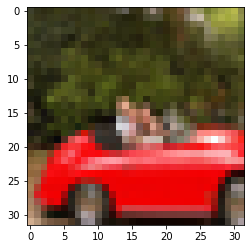

In [80]:
plt.imshow(train_dataset[2]), train_labels[2]

In [81]:
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [82]:
dataset = TensorDataset(torch.from_numpy(train_dataset), torch.from_numpy(train_labels.astype(int)))

# Data Split and Loader

In [83]:
def split_indices(n, val_pct):
    idx = np.random.permutation(n) #random numbers between 0 and the n given
    n_val = int(n * val_pct)
    idx_train = idx[n_val:]
    idx_val = idx[:n_val]
    return idx_train, idx_val

In [89]:
train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2)
print(f'{train_indices}, train shape : {train_indices.shape}, \n {val_indices}, val_shape : {val_indices.shape}')

[38663 18491 44511 ... 48582 14650 29556], train shape : (40000,), 
 [34916 11619 35450 ... 29031 25968  2695], val_shape : (10000,)


In [90]:
batch_size = 500
train_sampler = SubsetRandomSampler(train_indices) # taking the train indices and use only those for sampling
train_loader = DataLoader(dataset, batch_size, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices) # taking the val indices and use only those for sampling
val_loader = DataLoader(dataset, batch_size, sampler = val_sampler)

# Model

In [132]:
from torch import nn

input_size = 32*32*3
num_classes = 10

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 32*32*3)
        out = self.linear(xb)
        return out

model = CIFAR10Model()

In [133]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None ):
    preds = model(xb) # Notice it calls forward fucntion
    loss = loss_func(preds, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [134]:
def evaluate(model, loss_func, valid_dl, metric):
    with torch.no_grad(): ## needed because we dont want to recompute gradients for validation data
        results = [loss_batch(model, loss_func, xb, yb, opt=None, metric = metric) 
                   for xb, yb in valid_dl]
        
        # results will be stored for each batch of validation data
        
        losses, batch_size_list, metric_values = zip(*results) #unlist and separate each
        total_validation_rows = np.sum(batch_size_list)
        avg_loss = np.sum(np.multiply(losses , batch_size_list)) / total_validation_rows 
        #batch size could be different for the last batch so doing weighted average
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metric_values, batch_size_list)) / total_validation_rows
            
        return avg_loss, total_validation_rows, avg_metric

In [135]:
def accuracy(outputs, labels):
    # Apply softmax for each row
    probs = F.softmax(outputs, dim=1) 
    _, preds = torch.max(probs, dim = 1) 
    
    return torch.sum(preds == labels).item() / len(labels)

# Model Fit

In [136]:
def fit(epochs, model, loss_fn, opt, train_dl, val_dl, metric = None):
    for epoch in range(epochs):
        # TRAINING
        for xb, yb in train_dl:
            loss,_1,_2 = loss_batch(model, loss_fn, xb, yb, opt, metric)

        # EVALUATION on train data
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        
        print()
        print(f'Epoch: {epoch + 1}/{epochs}')
        print(f'Loss: {round(val_loss, 3)}')
        if metric is not None:
            print(f'{metric.__name__} : {round(val_metric*100, 2)}%')

In [137]:
import torch.nn.functional as F
# define model and optimizer
model = CIFAR10Model()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = F.cross_entropy

In [139]:
fit(100, model, loss_fn, optimizer, train_loader, val_loader, accuracy)


Epoch: 1/100
Loss: 1.755
accuracy : 39.99%

Epoch: 2/100
Loss: 1.759
accuracy : 39.7%

Epoch: 3/100
Loss: 1.754
accuracy : 39.82%

Epoch: 4/100
Loss: 1.755
accuracy : 39.87%

Epoch: 5/100
Loss: 1.759
accuracy : 39.93%

Epoch: 6/100
Loss: 1.755
accuracy : 39.84%

Epoch: 7/100
Loss: 1.755
accuracy : 39.9%

Epoch: 8/100
Loss: 1.753
accuracy : 40.02%

Epoch: 9/100
Loss: 1.754
accuracy : 39.86%

Epoch: 10/100
Loss: 1.755
accuracy : 39.87%

Epoch: 11/100
Loss: 1.754
accuracy : 39.89%

Epoch: 12/100
Loss: 1.753
accuracy : 39.82%

Epoch: 13/100
Loss: 1.753
accuracy : 39.7%

Epoch: 14/100
Loss: 1.756
accuracy : 39.55%

Epoch: 15/100
Loss: 1.752
accuracy : 40.1%

Epoch: 16/100
Loss: 1.754
accuracy : 39.78%

Epoch: 17/100
Loss: 1.752
accuracy : 39.97%

Epoch: 18/100
Loss: 1.751
accuracy : 39.89%

Epoch: 19/100
Loss: 1.751
accuracy : 39.83%

Epoch: 20/100
Loss: 1.753
accuracy : 39.79%

Epoch: 21/100
Loss: 1.75
accuracy : 40.11%

Epoch: 22/100
Loss: 1.755
accuracy : 39.92%

Epoch: 23/100
Loss: 1.7

cifar accuracy for logistic regression is around 40% only [see here](https://github.com/wikiabhi/Cifar-10)

# Save Model

In [142]:
torch.save(model.state_dict(), "CIFARModeldict.pth")

# Load Model

In [143]:
model2 = CIFAR10Model()
model2.load_state_dict(torch.load("./CIFARModeldict.pth"))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0284,  0.0146,  0.0725,  ..., -0.0016, -0.0492, -0.0314],
                      [-0.0327, -0.0234,  0.0035,  ..., -0.0233, -0.0397, -0.0013],
                      [-0.0047, -0.0066, -0.0652,  ...,  0.0368,  0.0149, -0.0251],
                      ...,
                      [-0.0190,  0.0319,  0.0762,  ...,  0.0930,  0.0895, -0.0298],
                      [ 0.0676,  0.0559,  0.0618,  ..., -0.1165, -0.0178,  0.0728],
                      [-0.0302,  0.0422,  0.0930,  ...,  0.0910,  0.0619,  0.0427]])),
             ('linear.bias',
              tensor([-0.7047,  0.3015,  0.2120,  0.2843,  0.2675, -0.1934,  0.4381,  0.0699,
                      -0.6579,  0.0095]))])